In [25]:
#Tratando os dados
from random import seed
from csv import reader
import pandas

# Carregando arquivo CSV
def load_csv(filename):
	dataset = list()
	with open(filename, 'r') as file:
		csv_reader = reader(file)
		for row in csv_reader:
			if not row:
				continue
			dataset.append(row)
	return dataset
 
# Converte a coluna da string em float
def str_column_to_float(dataset, column):
	for row in dataset:
		row[column] = float(row[column].strip())
 
# Converte a coluna da string em inteiro
def str_column_to_int(dataset, column):
	class_values = [row[column] for row in dataset]
	unique = set(class_values)
	lookup = dict()
	for i, value in enumerate(unique):
		lookup[value] = i
	for row in dataset:
		row[column] = lookup[row[column]]
	return lookup
 
# Encontra os valores mínimo e máximo para cada coluna
def dataset_minmax(dataset):
	minmax = list()
	stats = [[min(column), max(column)] for column in zip(*dataset)]
	return stats
 
# Redimensiona colunas do conjunto de dados para o intervalo 0-1
def normalize_dataset(dataset, minmax):
	for row in dataset:
		for i in range(len(row)-1):
			row[i] = (row[i] - minmax[i][0]) / (minmax[i][1] - minmax[i][0])

#Carregando e preparando dados
seed(1)
filename = 'seed_dataset.csv'
dataset = load_csv(filename)
for i in range(len(dataset[0])-1):
	str_column_to_float(dataset, i)
# Converter coluna de classe em inteiros
str_column_to_int(dataset, len(dataset[0])-1)
# Normalizar variáveis de entrada
minmax = dataset_minmax(dataset)
normalize_dataset(dataset, minmax)

In [26]:
#Gerando um número aleatório de neurônios
import random
n = random.randint(1,8)
print("Nº de neurônios na camada escondida:",n,"\n")

Nº de neurônios na camada escondida: 3 



In [27]:
# Inicializando uma rede
from random import seed
from random import random
from matplotlib import pyplot as plt 

def initialize_network(n_inputs, n_hidden, n_outputs):
	network = list()
	hidden_layer = [{'Pesos':[random() for i in range(n_inputs + 1)]} for i in range(n_hidden)]
	network.append(hidden_layer)
	output_layer = [{'Pesos':[random() for i in range(n_hidden + 1)]} for i in range(n_outputs)]
	network.append(output_layer)
	return network
 
seed(1)
network = initialize_network(2, n, 2)
for layer in network:
	print(layer)

[{'Pesos': [0.13436424411240122, 0.8474337369372327, 0.763774618976614]}, {'Pesos': [0.2550690257394217, 0.49543508709194095, 0.4494910647887381]}, {'Pesos': [0.651592972722763, 0.7887233511355132, 0.0938595867742349]}]
[{'Pesos': [0.02834747652200631, 0.8357651039198697, 0.43276706790505337, 0.762280082457942]}, {'Pesos': [0.0021060533511106927, 0.4453871940548014, 0.7215400323407826, 0.22876222127045265]}]


In [28]:
#FORWARD PROPAGATION
'''Executa em cada camada da rede, calculando as saídas para cada neurônio. Todas as saídas de uma camada tornam-se entradas para os neurônios na próxima camada'''

from math import exp
#Calcula a ativação do neurônio para uma entrada
def activate(weights, inputs):
	activation = weights[-1]
	for i in range(len(weights)-1):
		activation += weights[i] * inputs[i]
	return activation

#Ativação do neurônio de transferência
def transfer(activation):
	return 1.0 / (1.0 + exp(-activation))

# Propagação Forward  da entrada para a saída da rede neural
def forward_propagate(network, row):
	inputs = row
	for layer in network:
		new_inputs = []
		for neuron in layer:
			activation = activate(neuron['Pesos'], inputs)
			neuron['Saída'] = transfer(activation)
			new_inputs.append(neuron['Saída'])
		inputs = new_inputs
	return inputs

# Teste do forward propagation
row = [1, 0, None]
output = forward_propagate(network, row)
print(output)

[0.8368824115602297, 0.7345146020181377]


In [29]:
#CÁLCULO DE ERRO DA REDE BACKPROPAGATION

from matplotlib import pyplot as plt
# Calcula a derivada de uma saída de neurônio
def transfer_derivative(output):
	return output * (1.0 - output)
 
# Erro de retropropagação e armazenamento no neurônios
def backward_propagate_error(network, expected):
	for i in reversed(range(len(network))):
		layer = network[i]
		errors = list()
		if i != len(network)-1:
			for j in range(len(layer)):
				error = 0.0
				for neuron in network[i + 1]:
					error += (neuron['Pesos'][j] * neuron['delta'])
				errors.append(error)
		else:
			for j in range(len(layer)):
				neuron = layer[j]
				errors.append(expected[j] - neuron['Saída'])
		for j in range(len(layer)):
			neuron = layer[j]
			neuron['delta'] = errors[j] * transfer_derivative(neuron['Saída'])
 
# Teste de erros da rede backpropagation
expected = [0, 1]
backward_propagate_error(network, expected)
for layer in network:
	print(layer)

[{'Pesos': [0.13436424411240122, 0.8474337369372327, 0.763774618976614], 'Saída': 0.7105668883115941, 'delta': -0.000643611770485358}, {'Pesos': [0.2550690257394217, 0.49543508709194095, 0.4494910647887381], 'Saída': 0.6691980263750579, 'delta': -0.01603230366401668}, {'Pesos': [0.651592972722763, 0.7887233511355132, 0.0938595867742349], 'Saída': 0.678187028346445, 'delta': -0.0026378021934133217}]
[{'Pesos': [0.02834747652200631, 0.8357651039198697, 0.43276706790505337, 0.762280082457942], 'Saída': 0.8368824115602297, 'delta': -0.11424301950777555}, {'Pesos': [0.0021060533511106927, 0.4453871940548014, 0.7215400323407826, 0.22876222127045265], 'Saída': 0.7345146020181377, 'delta': 0.05177042289648915}]


In [30]:

# Treinar a rede por um número fixo de épocas
def train_network(network, train, l_rate, n_epoch, n_outputs):
	for epoch in range(n_epoch):
		sum_error = 0
		for row in train:
			outputs = forward_propagate(network, row)
			expected = [0 for i in range(n_outputs)]
			expected[row[-1]] = 1
			sum_error += sum([(expected[i]-outputs[i])**2 for i in range(len(expected))])
			backward_propagate_error(network, expected)
			update_weights(network, row, l_rate)
		erros.append(sum_error/100)
		print('>epoch=%d, lrate=%.3f, error=%.3f' % (epoch, l_rate, sum_error/100))
 
# Atualizar pesos de rede com erro
def update_weights(network, row, l_rate):
	for i in range(len(network)):
		inputs = row[:-1]
		if i != 0:
			inputs = [neuron['Saída'] for neuron in network[i - 1]]
		for neuron in network[i]:
			for j in range(len(inputs)):
				neuron['Pesos'][j] += l_rate * neuron['delta'] * inputs[j]
			neuron['Pesos'][-1] += l_rate * neuron['delta']

# Realizar treino do algoritmo algoritmo
erros = []
n_inputs = len(dataset[0]) - 1
n_outputs = len(set([row[-1] for row in dataset]))
network = initialize_network(n_inputs, n, n_outputs)
train_network(network, dataset, 0.4, 100, n_outputs)
for layer in network:
	print(layer)

>epoch=0, lrate=0.400, error=0.363
>epoch=1, lrate=0.400, error=0.351
>epoch=2, lrate=0.400, error=0.355
>epoch=3, lrate=0.400, error=0.348
>epoch=4, lrate=0.400, error=0.337
>epoch=5, lrate=0.400, error=0.321
>epoch=6, lrate=0.400, error=0.298
>epoch=7, lrate=0.400, error=0.270
>epoch=8, lrate=0.400, error=0.239
>epoch=9, lrate=0.400, error=0.207
>epoch=10, lrate=0.400, error=0.176
>epoch=11, lrate=0.400, error=0.149
>epoch=12, lrate=0.400, error=0.125
>epoch=13, lrate=0.400, error=0.106
>epoch=14, lrate=0.400, error=0.090
>epoch=15, lrate=0.400, error=0.078
>epoch=16, lrate=0.400, error=0.068
>epoch=17, lrate=0.400, error=0.061
>epoch=18, lrate=0.400, error=0.055
>epoch=19, lrate=0.400, error=0.050
>epoch=20, lrate=0.400, error=0.045
>epoch=21, lrate=0.400, error=0.042
>epoch=22, lrate=0.400, error=0.039
>epoch=23, lrate=0.400, error=0.037
>epoch=24, lrate=0.400, error=0.035
>epoch=25, lrate=0.400, error=0.033
>epoch=26, lrate=0.400, error=0.031
>epoch=27, lrate=0.400, error=0.030
>e

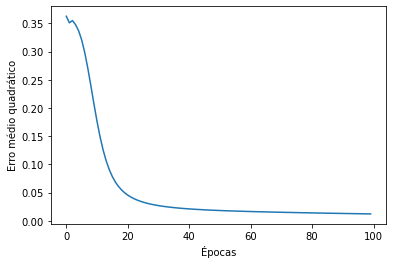

In [31]:
#Plotando gráfico de erro médio quadrático
epocas = range(0,len(erros))
plt.plot(epocas, erros)
plt.ylabel('Erro médio quadrático')
plt.xlabel('Épocas')
plt.show()

In [32]:
# Fazendo uma previsão com a rede
from math import exp
obtidos = []
esperados = []
def predict(network, row):
	outputs = forward_propagate(network, row)
	return outputs.index(max(outputs))

for row in dataset:
	prediction = predict(network, row)
	obtidos.append(prediction)
	esperados.append(row[-1])
	print('Esperado=%d, Obtido=%d' % (row[-1], prediction))

Esperado=1, Obtido=1
Esperado=1, Obtido=1
Esperado=1, Obtido=1
Esperado=1, Obtido=1
Esperado=1, Obtido=1
Esperado=1, Obtido=1
Esperado=1, Obtido=1
Esperado=1, Obtido=1
Esperado=1, Obtido=1
Esperado=1, Obtido=1
Esperado=1, Obtido=1
Esperado=1, Obtido=1
Esperado=1, Obtido=1
Esperado=1, Obtido=1
Esperado=1, Obtido=1
Esperado=1, Obtido=1
Esperado=1, Obtido=1
Esperado=1, Obtido=0
Esperado=1, Obtido=0
Esperado=1, Obtido=1
Esperado=1, Obtido=1
Esperado=1, Obtido=1
Esperado=1, Obtido=1
Esperado=1, Obtido=1
Esperado=1, Obtido=0
Esperado=1, Obtido=1
Esperado=1, Obtido=1
Esperado=1, Obtido=1
Esperado=1, Obtido=1
Esperado=1, Obtido=1
Esperado=1, Obtido=1
Esperado=1, Obtido=1
Esperado=1, Obtido=1
Esperado=1, Obtido=1
Esperado=1, Obtido=1
Esperado=1, Obtido=1
Esperado=1, Obtido=1
Esperado=1, Obtido=1
Esperado=1, Obtido=1
Esperado=1, Obtido=1
Esperado=1, Obtido=1
Esperado=1, Obtido=1
Esperado=1, Obtido=1
Esperado=1, Obtido=1
Esperado=1, Obtido=1
Esperado=1, Obtido=1
Esperado=1, Obtido=1
Esperado=1, O

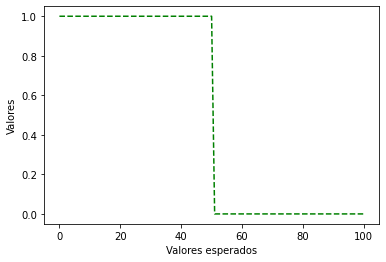

In [33]:
# Plotando gráfico de valores esperados
val = range(0,len(esperados))
plt.plot(val, esperados,'g--')
plt.ylabel('Valores')
plt.xlabel('Valores esperados')
plt.show()

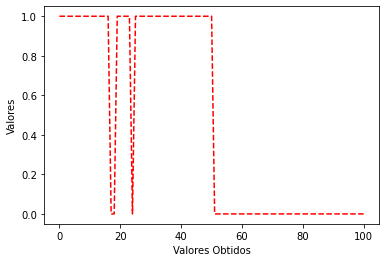

In [34]:
# Plotando gráfico de valores obtidos
plt.plot(val, obtidos,'r--')
plt.ylabel('Valores')
plt.xlabel('Valores Obtidos')
plt.show()

In [35]:
# Backpropagation no conjunto de dados de sementes de trigo
from random import seed
from random import randrange
from random import random
from math import exp
import pandas
from urllib.request import urlretrieve
from matplotlib import pyplot as plt
erros = []
esperado = []
obtido = [] 
pesos = []

# Divide um conjunto de dados em k dobras
def cross_validation_split(dataset, n_folds):
	dataset_split = list()
	dataset_copy = list(dataset)
	fold_size = int(len(dataset) / n_folds)
	for i in range(n_folds):
		fold = list()
		while len(fold) < fold_size:
			index = randrange(len(dataset_copy))
			fold.append(dataset_copy.pop(index))
		dataset_split.append(fold)
	return dataset_split

# Calcula a porcentagem de acurácia
def accuracy_metric(actual, predicted):
	correct = 0
	for i in range(len(actual)):
		if actual[i] == predicted[i]:
			correct += 1
	return correct / float(len(actual)) * 100.0

# Treinar a rede por um número fixo de épocas
def train_network(network, train, l_rate, n_epoch, n_outputs):
	for epoch in range(n_epoch):
		for row in train:
			outputs = forward_propagate(network, row)
			expected = [0 for i in range(n_outputs)]
			expected[row[-1]] = 1
			
			backward_propagate_error(network, expected)
			update_weights(network, row, l_rate)


# Avalia um algoritmo usando uma divisão de validação cruzada
def evaluate_algorithm(dataset, algorithm, n_folds, *args):
	folds = cross_validation_split(dataset, n_folds)
	scores = list()
	for fold in folds:
		train_set = list(folds)
		train_set.remove(fold)
		train_set = sum(train_set, [])
		test_set = list()
		for row in fold:
			row_copy = list(row)
			test_set.append(row_copy)
			row_copy[-1] = None
		predicted = algorithm(train_set, test_set, *args)
		actual = [row[-1] for row in fold]
		accuracy = accuracy_metric(actual, predicted)
		scores.append(accuracy)
	return scores

# Algoritmo Backpropagation com descida gradiente estocástico
def back_propagation(train, test, l_rate, n_epoch, n_hidden):
	n_inputs = len(train[0]) - 1
	n_outputs = len(set([row[-1] for row in train]))
	network = initialize_network(n_inputs, n_hidden, n_outputs)
	train_network(network, train, l_rate, n_epoch, n_outputs)
	predictions = list()
	for row in test:
		prediction = predict(network, row)
		predictions.append(prediction//1)
		obtido.append(predictions[-1]//2)
		esperado.append(row)
	return(predictions)

n_folds = 5 #número de dobras
l_rate = 0.3 #taxa de aprendizagem
n_epoch = 100 #número de épocas
n_hidden = n #número de neurônios na camada oculta

scores = evaluate_algorithm(dataset, back_propagation, n_folds, l_rate, n_epoch, n_hidden)
print('Scores: %s' % scores)
print('Acurácia: %.3f%%' % (sum(scores)/float(len(scores))))

Scores: [100.0, 100.0, 100.0, 95.0, 95.0]
Acurácia: 98.000%
